<a href="https://colab.research.google.com/github/berthine/Matrix-Factorization-and-Tensor-methods/blob/master/AMMI_Image_compression_practice_LAB1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
!pip install tensorly
import torch
from torch.autograd import Variable
import tensorly as tl
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.random import check_random_state
tl.set_backend('pytorch')
from torchvision import datasets
from torch.optim.lr_scheduler import StepLR
np.random.seed(0)

     |████████████████████████████████| 71kB 2.9MB/s 
     |████████████████████████████████| 163kB 8.6MB/s 
  Created wheel for tensorly: filename=tensorly-0.4.5-cp36-none-any.whl size=100156 sha256=ab1cfc3a3bc28f62956e75ddd8239a6866cf9ba575974650dfffecc74b08638e
  Stored in directory: /root/.cache/pip/wheels/44/ae/02/8d00229a4fd0af192b48d24da903f9975c7ac10e706685fc39
Successfully built tensorly


# Practice 1: The magical einsumfunction


*Einstein notation* is a convenient way to lighten mathematical expressions involving summations and relies on the simple convention that indices appearing twice in an expression are summed over (this is actually a naive simplification where we omit the distinction between so-called _covariant_ and _contravariant_ indices). 

For example, the inner product between two vectors $u$ and $v$ is written as
$$u_iv_i := \sum_i u_iv_i.$$

When an index appears only once, it corresponds to free indices of the resulting tensor. For example $A_{ik}B_{kj}$ has two free indices, $i$ and $j$, and thus corresponds to a second-tensor~(aka matrix) whose components $(i,j)$ is given by $\sum_k A_{ik}B_{kj}$ (aka the matrix product of $A$ and $B$). Similarly, the outer product of two vectors $u$ and $v$ is noted $u_iv_j$.


The `einsum` function from the numpy package is inspried from this convention and makes it easy to write contractions between tensors. The function uses *signature* strings to specify contractions between tensors. For example, `'ij,jk->ki'` denotes a contraction between two 2nd-order tensors~(i.e., matrices $A$ and $B$), the indices of the first one are $i$ and $j$ and the indices of the second one are $j$ and $k$. Since $j$ appears twice it is summed over and the indices appearing after the right arrow `->` specify the order of the indices in the resulting tensor. Thus, `'ij,jk->ki'` corresponds to $(AB)^\top$.

More precisely, a signature strings is interpreted using these two simple rules:

- if an index appears in several input arrays, it means that the corresponding modes (are axes in numpy terminology) should be mutliplied together
- if an index appears at the left of the arrow sign `->` but not at the right, it means that is should be summed over


Here are a couple examples (`u`, `v` and `w` are numpy 1d arrays, `A` and `B` are two 2d arrays and `T` is a 3d array):

- inner product: `np.einsum('i,i->',u,v)`
- outer product: `np.einsum('i,j->ij',u,v)`
- outer product between three vectors: `np.einsum('i,j,k->ijk',u,v,w)`
- "3-way contraction" between three vectors: `np.einsum('i,i,i->',u,v,w)`
- sum of elements of a vector: `np.einsum('i->')`
- transpose: `np.einsum('ij->ji',A)`
- trace of a matrix: `np.einsum('ii->',A)`
- diagonal of a matrix: `np.einsum('ii->i',A)`
- element-wise multiplication of two matrices: `np.einsum('ij,ij->ij',A,B)`
- sum of the product of the diagonal elements of two matrices: `np.einsum('ii,ii->',A,B)`
- mode-2 product: `np.einsum('ijk,jl->ilk',T,A)`

Write the following functions with only one line using the einsum function:

$$G \times_1 A \times_2 B \times_3 C$$

$ ((A,B,C,D))_{ijkl} = \sum_{r_1,r_2,r_3,r_4} A_{r_1,i,r_2}B_{r_2,j,r_3}C_{r_3,k,r_4}D_{r_4,l,r_1}$

In [10]:
import numpy as np
def inner_product(S,T):
    """
    S,T: two tensors of order 3
    
    returns the inner product between the two
    """
     
    DP = np.einsum( 'ijk, ijk', S, T)
    return DP

def tucker_to_tensor(G,A,B,C):
    """
    G: 3rd order core tensor 
    A,B,C: factor matrices
    
    returns the tensor with Tucker decomposition $$G \times_1 A \times_2 B \times_3 C$$
    """
    result = np.einsum('ijk,ai,bj,ck -> abc', G,A,B,C)
    return result  

def cp_to_tensor(A,B,C):
    """
    A,B,C: factor matrices (same number of columns in each)
    
    returns the tensor with CP decomposition $$[[A,B,C]]$$
    """
    return np.einsum('im, jm, km -> ijk', A,B,C)

def tt_to_tensor(A,B,C,D):
    """
    A,B,C,D: core tensors (A and D are order 2, and B and C are order 3)
    
    returns the tensor with tensor train decomposition $$<<A,B,C,D>>$$
    """
    res_ = np.einsum('ir,rjs, skt, tl-> ijkl', A,B,C,D)

    return res_
    
def tr_to_tensor(A,B,C,D):
    """
    A,B,C,D: core tensors (all of order 3)
    
    returns the tensor with tensor ring decomposition $$((A,B,C,D))$$. Recall that the tensor ring decomposition
    is defined by
    ((A,B,C,D))_{ijkl} = \sum_{r_1,r_2,r_3,r_4} A_{r_1,i,r_2}B_{r_2,j,r_3}C_{r_3,k,r_4}D_{r_4,l,r_1}
    """
    return np.einsum('uir, rjs, skt, tlu ->ijkl', A,B,C,D)

Run the following cell to check whether your implementation of these functions is correct:

In [11]:
import tensorly as tl
tl.set_backend('numpy')
G = tl.tensor(np.random.normal(0,1,[10,11,12]))
T = tl.tensor(np.random.normal(0,1,[10,11,12]))
A,B,C = [np.random.normal(0,1, [d,4]) for d in [10,11,12]]
D,E,F = [np.random.normal(0,1, [d,r]) for d,r in zip([15,15,14],[10,11,12])]
G1,G2,G3,G4 = [np.random.normal(0,1, [r1,d,r2]) for r1,d,r2 in zip([3,4,5,6],[9,8,7,8],[4,5,6,3])]


try:
    print("inner_product: ok" if np.allclose(tl.tenalg.inner(G,T), inner_product(G,T)) else "inner_product: failed")
except Exception as e:
    print("inner_product: exception raised \n",e)
print()                
try:
    print("tucker_to_tensor: ok" if np.allclose(tl.tucker_to_tensor((G,[D,E,F])), tucker_to_tensor(G,D,E,F)) else "tucker_to_tensor: failed")
except Exception as e:
    print("tucker_to_tensor: exception raised \n",e)
print() 
try:
    print("cp_to_tensor: ok" if np.allclose(tl.kruskal_to_tensor((np.ones(4),(A,B,C))), cp_to_tensor(A,B,C)) else "cp_to_tensor: failed")
except Exception as e:
    print("cp_to_tensor: exception raised \n",e)
print() 
try:
    print("tt_to_tensor: ok" if np.allclose(tl.mps_to_tensor((G1[:1,:,:],G2,G3,G4[:,:,:1])), tt_to_tensor(G1[0,:,:],G2,G3,G4[:,:,0])) else "tt_to_tensor: failed")
except Exception as e:
    print("tt_to_tensor: exception raised \n",e)
print() 
try:
    print("tr_to_tensor: ok" if np.allclose(sum([tl.mps_to_tensor([G1[i:i+1,:,:],G2,G3,G4[:,:,i:i+1]]) for i in range(3)]), tr_to_tensor(G1,G2,G3,G4)) else "tr_to_tensor: failed")
except Exception as e:
    print("tr_to_tensor: exception raised \n",e)   

inner_product: ok

tucker_to_tensor: ok

cp_to_tensor: ok

tt_to_tensor: ok

tr_to_tensor: ok


# Practice 2: Tensorly introduction
As you might have already noticed, in the above test, we have used some functions from the package 'Tensorly' to give the answer. 'Tensorly' is a popular alternative for many basic tensor operations and algorithms. In this practice, you will explore and get familiar with the primary data type "tensor" in 'Tensorly' and try various built-in tensor-related methods. Below is the link to Tensorly's API page. In this particular practice, you are allowed to use any function (if not specified) from Tensorly. 

http://tensorly.org/stable/modules/api.html

## (a) Tensor type in Tensorly
Tensorly's primary data structure is "tensor". In fact, it is straight forward to convert a numpy array to tensorly's tensor and vice versa. In this practice, you need to generate 1 random vector $a$ of size 5 and 2 random matrices $A$, $B$ of size 5*5, using the function `np.random.rand()`, then you need to convert them to tensorly's tensor type and then convert them back to numpy's array type. Use the function `type()` to check if you have the correct data type. (Note if we use pytorch as the backend of tensorly, the returned tensor will have type 'torch.Tensor', otherwise if we use numpy as the backend, which is the default setting, the returned tensor will be of the type 'numpy.ndarray').


In [12]:
a = np.random.rand(5)
A = np.random.rand(5,5)
B = np.random.rand(5,5)

In [13]:
a

array([0.2017858 , 0.19281317, 0.31834615, 0.89746816, 0.05457466])

In [14]:
np.einsum('i->',a)

1.6649879562786665

In [15]:
A

array([[0.3012639 , 0.24771521, 0.60127988, 0.2070745 , 0.01068053],
       [0.15385391, 0.36193366, 0.80346892, 0.84691843, 0.64659873],
       [0.4138493 , 0.65155583, 0.1952568 , 0.79107071, 0.44328237],
       [0.96547454, 0.25811086, 0.63944066, 0.85353904, 0.24630087],
       [0.02200961, 0.43702606, 0.51187364, 0.21604095, 0.80455184]])

In [16]:
print(type(a))
print(type(A))
print(type(B))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [17]:
## convert vec, matrices to tensor
tl.set_backend('pytorch')
a_t = tl.tensor(a)
A_t = tl.tensor(A)
B_t = tl.tensor(B)

In [18]:
print(type(a_t))
print(type(A_t))
print(type(B_t))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [20]:

a = tl.to_numpy(a_t)
A = tl.to_numpy(A_t)
B = tl.to_numpy(B_t)

In [21]:
print(type(a))
print(type(A))
print(type(B))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [35]:
type(tl.tensor(B))

numpy.ndarray

## (b) Contraction operation between vectors/matrices
Recall that contraction between two tensors is essentially summing over one or multiple dimensions (legs) between the two tensors. In Tensorly, this operatation can be done by using the method `tl.tenalg.contract()`. Now compute the following vector matrix multiplication and matrix matrix multiplication: 1) $a^T A$; 2) $AB$ using tensorly's built-in method `tl.tenalg.contract()`. 

In [28]:
result1 = tl.tenalg.contract(a_t,[0], A_t,[1])
result2 = tl.tenalg.contract(A_t,[1], B_t,[0])
print(result1)
print(result2)

tensor([0.4864, 1.1520, 1.0054, 1.2276, 0.4895])
tensor([[0.8645, 0.5073, 0.6073, 0.4912, 0.4471],
        [1.8231, 0.9041, 1.4624, 1.5366, 0.9677],
        [1.3687, 1.1909, 1.5974, 1.5099, 1.2006],
        [1.9393, 1.1017, 1.8870, 1.6187, 1.1273],
        [1.2811, 0.8175, 1.0445, 1.0579, 0.6661]])


##(c) Contraction operation between tensors
Use `np.random.rand` generate a tensor C of shape (4,5,6,7,8) and D of shape (2, 3, 7, 6, 9) and convert them to tensorly's tensor type. Then use `tl.tenalg.contract` to contract C and D on the third, fourth dimension of C and fourth, third dimension of D and return your result. (Hint, the final shape should be (4,5,8,2,3,9))

In [29]:
C=np.random.rand(4,5,6,7,8)
D = np.random.rand(2,3,7,6,9)

In [33]:
C_t = tl.tensor(C)
D_t = tl.tensor(D)

result = tl.tenalg.contract(C_t, [2,3], D_t, [3,2])
print(result.shape)

torch.Size([4, 5, 8, 2, 3, 9])


In [36]:
len(result.shape)

6

## (d) Unfold and fold operation (matrixization)


As we have already learned in class, given a tensor or arbitrary shape, we sometimes will perform operations on its matrixization format. For example, given a tensor of shape $(d_1, d_2, d_3)$, the mode-1 matrixization (unfolding) is a matrix of shape $(d_1, d_2\times d_3)$. In Tensorly, this operation can be done via the function `tl.base.unfold` and to re-fold the matrix back to its tensor format, one can use the function `tl.base.fold`. 

Use the answer of question (c), compute the mode-1 to mode-6 matrixizations of the tensor and check if the dimension matches the desried values. Then use any mode matrixization and the `fold` function to reconstruct the original tensor. 

In [37]:
from tensorly.base import fold, unfold

for i in range(len(result.shape)):
  unfolded = unfold(result,i)
  print(unfolded.shape)
  folded = fold( unfolded, i, result.shape)
  print(folded.shape)

torch.Size([4, 2160])
torch.Size([4, 5, 8, 2, 3, 9])
torch.Size([5, 1728])
torch.Size([4, 5, 8, 2, 3, 9])
torch.Size([8, 1080])
torch.Size([4, 5, 8, 2, 3, 9])
torch.Size([2, 4320])
torch.Size([4, 5, 8, 2, 3, 9])
torch.Size([3, 2880])
torch.Size([4, 5, 8, 2, 3, 9])
torch.Size([9, 960])
torch.Size([4, 5, 8, 2, 3, 9])


Similarly you can also vectorize one tensor and recover a tensor from its vectorized format. Use the function `tl.base.tensor_to_vec` to vectorize the result you got from (c) and use the function `tl.base.vec_to_tensor` to recover the original tensor from its vectorized format.

In [38]:
from tensorly.base import tensor_to_vec, vec_to_tensor

print(tensor_to_vec(result).shape)
print(vec_to_tensor(tensor_to_vec(result), result.shape).shape)

torch.Size([8640])
torch.Size([4, 5, 8, 2, 3, 9])


# Practice 3: Image compression

Images can be naturally seen as a third order tensor of shape (length, width, number of pixel channels). In fact, one can even simply reshape the images to obtain a higer dimensional tensor. In this practice, you will work with a image and reshape it into a higher order tensor and use various tensor decomposition methods to compress the image. 

In [39]:
from io import BytesIO
from google.colab import files
from PIL import Image
!wget -nc "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_(test_image).png"

im = Image.open('Lenna_(test_image).png')

--2020-07-20 22:54:50--  https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_(test_image).png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘Lenna_(test_image).png’

Lenna_(test_image). 100%[===================>] 462.73K  --.-KB/s    in 0.09s   

2020-07-20 22:54:50 (4.88 MB/s) - ‘Lenna_(test_image).png’ saved [473831/473831]



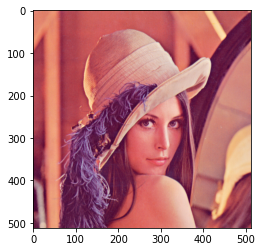

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.imshow(im)
plt.show()

(512, 512, 3)


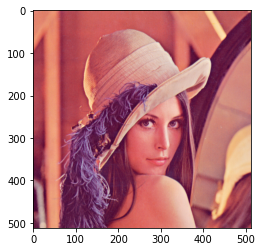

In [41]:
# check tensor shape
im_arr = np.asarray(im)
print(im_arr.shape)

# convert numpy array to tensorly's tensor type
im_ten = tl.tensor(im_arr)
# You can directly show a tensorly tensor as an image using `imshow`
plt.imshow(im_ten/255.)  # you need to divide the tensor by 255 to put the values in the range (0,1)
plt.show()

In [42]:
im_ten.shape

torch.Size([512, 512, 3])

## (a)
Use the method `tl.reshape` to reshape the input tensor to (16, 16, 16, 16, 12)

In [47]:
im_ten_reshaped = tl.reshape(im_ten, [16,16,16,16,12])
print(im_ten_reshaped.shape)

torch.Size([16, 16, 16, 16, 12])


##(b)
Use the tensorly method `tensorly.decomposition.parafac` to perform CP decomposition with cp_rank = 10.

In [44]:
from tensorly.decomposition import parafac

In [48]:
tl.set_backend('pytorch')

cp_rank =10
im_cp = parafac(im_ten_reshaped, cp_rank)

#(c) 
Recover the tensor compresed by CP using tensorly method `tensorly.kruskal_to_tensor` and replot the image. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


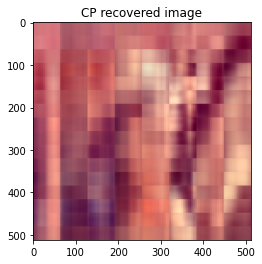

In [46]:
from tensorly import kruskal_to_tensor
im_cp_rec = kruskal_to_tensor(im_cp).reshape(im_ten.shape)
plt.imshow(im_cp_rec/255.)
plt.title('CP recovered image')
plt.show()

##(d)
Use the tensorly method `tensorly.decomposition.tucker` to perform CP decomposition with tucker_rank = 10 for every dimension. Then find the corresponding function to compute the reconstructed tensor and plot the image. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


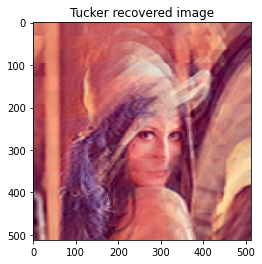

In [49]:
from tensorly.decomposition import tucker, matrix_product_state

tucker_rank = 10 * np.ones(im_ten_reshaped.ndim)
im_tucker = tucker(im_ten_reshaped, tucker_rank)

from tensorly import tucker_to_tensor
im_tucker_rec = tucker_to_tensor(im_tucker).reshape(im_ten.shape)
im_tucker_rec_numpy = tl.to_numpy(im_tucker_rec)
im_tucker_pic = Image.fromarray((im_tucker_rec_numpy).astype(np.uint8))
plt.imshow(im_tucker_rec/255.)
plt.title('Tucker recovered image')
plt.show()

##(e) 
Find the function in Tensorly to perform tensor train (matrix product state) decomposition with maximum TT rank 10 for all cores. Then find the function to compute the reconstructed tensor and plot the image. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


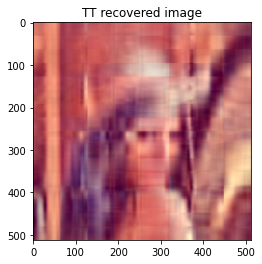

In [51]:
from tensorly.decomposition import matrix_product_state

tt_rank = 10
im_tt = matrix_product_state(im_ten_reshaped, tt_rank)

from tensorly import mps_to_tensor
im_tt_rec = mps_to_tensor(im_tt).reshape(im_ten.shape)
im_tt_rec_numpy = tl.to_numpy(im_tt_rec)
im_tt_pic = Image.fromarray((im_tt_rec_numpy).astype(np.uint8))
plt.imshow(im_tt_rec/255.)
plt.title('TT recovered image')
plt.show()

##(f) 
Do your recovered images all look the same? If not, why is that?

##(g) 
Compute the number of parameters for each decomposition. 

In [52]:
def compute_tt_num(factors):
  return np.sum([tl.to_numpy(f).size for f in factors])
def compute_cp_num(weights, factors):
  return tl.to_numpy(weights).size + np.sum([tl.to_numpy(f).size for f in factors]) 
def compute_tucker_num(core, factors):
  return tl.to_numpy(core).size + np.sum([tl.to_numpy(f).size for f in factors])

print('TT number: ', compute_tt_num(im_tt))
print('CP number: ', compute_cp_num(im_cp[0], im_cp[1]))
print('Tucker number: ', compute_tucker_num(im_tucker[0], im_tucker[1]))

TT number:  5080
CP number:  770
Tucker number:  100760


### [Bonus] Explore the relationship between reconstruction error and number of parameters.
For the bonus question, we encourage you to explore the relationship between reconstruction error (namely MSE) and the number of parameters for tensor train decomposition method. To be exact, in this question, try various of maximum TT-decomposition ranks and draw a figure show case the decline of MSE w.r.t. number of parameters. In addition, plot all the recovered images and observe the changes w.r.t rank/number of parameters.

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline  
def compute_MSE(ori, pred):
  return np.mean((ori - pred)**2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


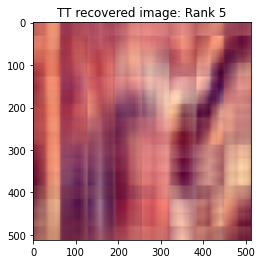

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


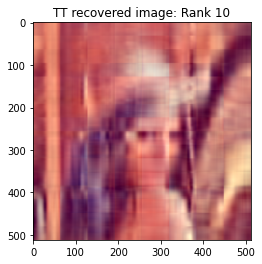

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


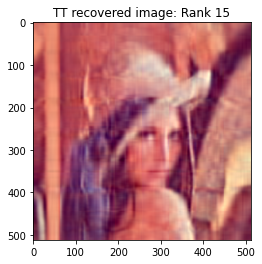

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


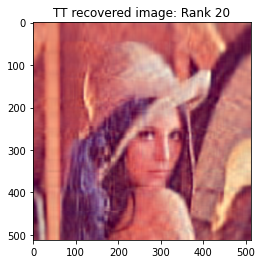

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


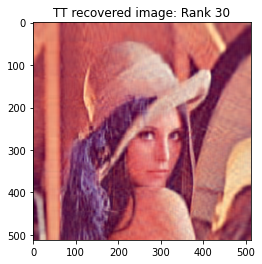

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


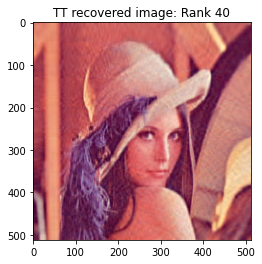

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


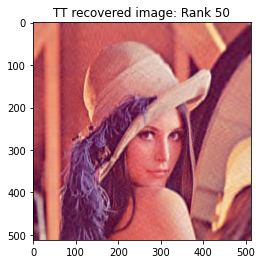

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


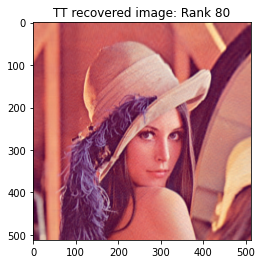

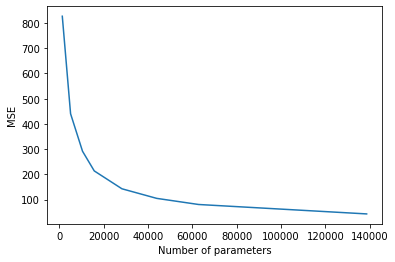

In [55]:

TT_rank = [5, 10,  15,  20, 30, 40, 50,80]

tt_mse = []
tt_num_para = []

for tt_rank in TT_rank:
  im_tt = matrix_product_state(im_ten_reshaped, tt_rank)

  im_tt_rec = mps_to_tensor(im_tt).reshape(im_ten.shape)
  tt_mse.append(compute_MSE(im_arr, tl.to_numpy(im_tt_rec)))
  tt_num_para.append(compute_tt_num(im_tt))
  im_tt_rec_numpy = tl.to_numpy(im_tt_rec)
  im_tt_pic = Image.fromarray((im_tt_rec_numpy).astype(np.uint8))
  plt.imshow(im_tt_rec/255.)
  plt.title('TT recovered image: Rank '+ str(tt_rank))
  plt.show()



plt.plot(tt_num_para, tt_mse)
plt.ylabel('MSE')
plt.xlabel('Number of parameters')
plt.show()



